Link to content in google drive: https://drive.google.com/drive/folders/1tVUz9gMh0rtJdHDSNMBcduqzLT0DWA0b?usp=sharing



# Preparation

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
% cd /content/drive/MyDrive/DL_project/Swin-Transformer-main
! pwd

/content/drive/MyDrive/DL_project/Swin-Transformer-main
/content/drive/MyDrive/DL_project/Swin-Transformer-main


In [4]:
! pip install timm

     |████████████████████████████████| 348kB 13.6MB/s 


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import time
import os
import copy
import timm

path_to_content = '/content/drive/MyDrive/DL_project/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Arctica classification model

In [6]:
% cd models
! ls

/content/drive/MyDrive/DL_project/Swin-Transformer-main/models
build.py  __init__.py  __pycache__  swin_transformer.py


In [7]:
from swin_transformer import SwinTransformer
NUM_CLASSES = 20

## ResNet

In [8]:
model_ft_resnet = models.resnet50(pretrained=True)
num_ftrs = model_ft_resnet.fc.in_features
model_ft_resnet.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft_resnet.to(device)
pytorch_total_params = sum(p.numel() for p in model_ft_resnet.parameters() if p.requires_grad)
print('Number of parameters =', pytorch_total_params)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Number of parameters = 23549012


## Checkpoints (tiny, small)

Могут быть проблемы с памятью

In [20]:
configs = {}
configs['tiny'] = {'NAME': 'swin_tiny_patch4_window7_224',
  'DROP_PATH_RATE': 0.2,
  'EMBED_DIM': 96,
  'DEPTHS': [ 2, 2, 6, 2 ],
  'NUM_HEADS': [ 3, 6, 12, 24 ],
  'WINDOW_SIZE': 7}

configs['small'] = {'NAME': 'swin_small_patch4_window7_224',
  'DROP_PATH_RATE': 0.3,
  'EMBED_DIM': 96,
  'DEPTHS': [ 2, 2, 18, 2 ],
  'NUM_HEADS': [ 3, 6, 12, 24 ],
  'WINDOW_SIZE': 7}

configs['small'] = {'NAME': 'swin_base_patch4_window7_224',
  'DROP_PATH_RATE': 0.5,
  'EMBED_DIM': 128,
  'DEPTHS': [ 2, 2, 18, 2 ],
  'NUM_HEADS': [ 4, 8, 16, 32 ],
  'WINDOW_SIZE': 7}

def build_model(model_type):
    model = SwinTransformer(embed_dim=configs[model_type]['EMBED_DIM'],
                          depths=configs[model_type]['DEPTHS'],
                          num_heads=configs[model_type]['NUM_HEADS'],
                          window_size=configs[model_type]['WINDOW_SIZE'],
                          drop_path_rate=configs[model_type]['DROP_PATH_RATE'],
                          )
    PATH = "/content/drive/MyDrive/DL_project/Swin-Transformer-main/checkpoints/" + configs[model_type]['NAME'] + '.pth'
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model'])
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(device)
    return model

model_type = 'small'
model_ft = build_model(model_type)
pytorch_total_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'Number of parameters in {model_type} model = {pytorch_total_params}')

Number of parameters in small model = 86763724


# Dataloader

In [10]:
image_size = 224
batch_size = 128
if model_type == 'small':
  batch_size = 32
elif model_type == 'base':
  batch_size = 16


data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop((800, 1000)), #remove bottom digits in some pictures
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size + 32),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'holdout': transforms.Compose([
        transforms.Resize(image_size + 32),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = path_to_content + "arctic_classification_all"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'holdout']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'holdout']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'holdout']}
class_names = image_datasets['train'].classes

dataset_sizes

{'holdout': 645, 'train': 1903, 'val': 636}

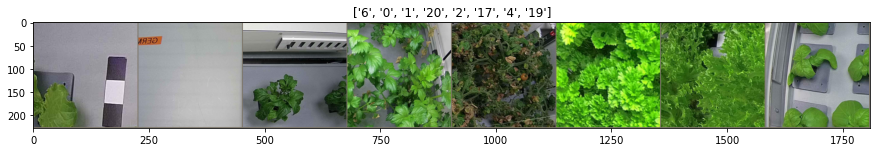

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 30))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in classes[:8]])

# Train, evaluate and visualisation functions

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    acc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n = 0
            for inputs, labels in dataloaders[phase]:
                n += 1
                if n % (len(dataloaders[phase]) // 2) == 0:
                  print(f'batch: {n}/{len(dataloaders[phase])}')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train': #uncomment if using StepLR scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}, accuracy: {:4f}'.format(best_loss, acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss

In [13]:
def evaluate_model(model, criterion):
  phase = 'holdout'
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0

  # Iterate over data.
  for inputs, labels in dataloaders[phase]:

      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_sizes[phase]
  epoch_acc = running_corrects.double() / dataset_sizes[phase]
  print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
  return epoch_acc

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['holdout']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('pred: {}, true: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft)
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, len(dataloaders['train']))

In [ ]:
from time import gmtime, strftime
num_epochs = 25
DO_TRAIN = False
if DO_TRAIN = True:
  model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=num_epochs)
  acc_holdout = evaluate_model(model_ft, criterion)
  name = model_type+'_'+str(round(acc_holdout.item(), 4))+strftime("_%d-%m_%H:%M.pth", gmtime())
  print(name)
  path_save = path_to_content + f"arctic_classification_all/checkpoints/{name}"
  torch.save({
              'epoch': num_epochs,
              'model_state_dict': model_ft.state_dict(),
              'optimizer_state_dict': optimizer_ft.state_dict(),
              'holdout_acc': acc_holdout,
              'criterion': criterion,
              'scheduler': exp_lr_scheduler
              }, path_save)

# Load and evaluate on holdout

In [25]:
model_type = 'small'
model_ft_loaded = build_model(model_type)

optimizer = optim.SGD(model_ft_loaded.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

name = "tiny.pth"
if model_type == 'small':
  name = "small.pth"

path_load = path_to_content + f"arctic_classification_all/checkpoints/{name}"
checkpoint = torch.load(path_load)

model_ft_loaded.load_state_dict(checkpoint['model_state_dict'])
model_ft_loaded.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [23]:
hold_out_acc = evaluate_model(model_ft_loaded, criterion)

holdout Loss: 0.0444 Acc: 0.9860


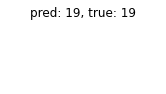

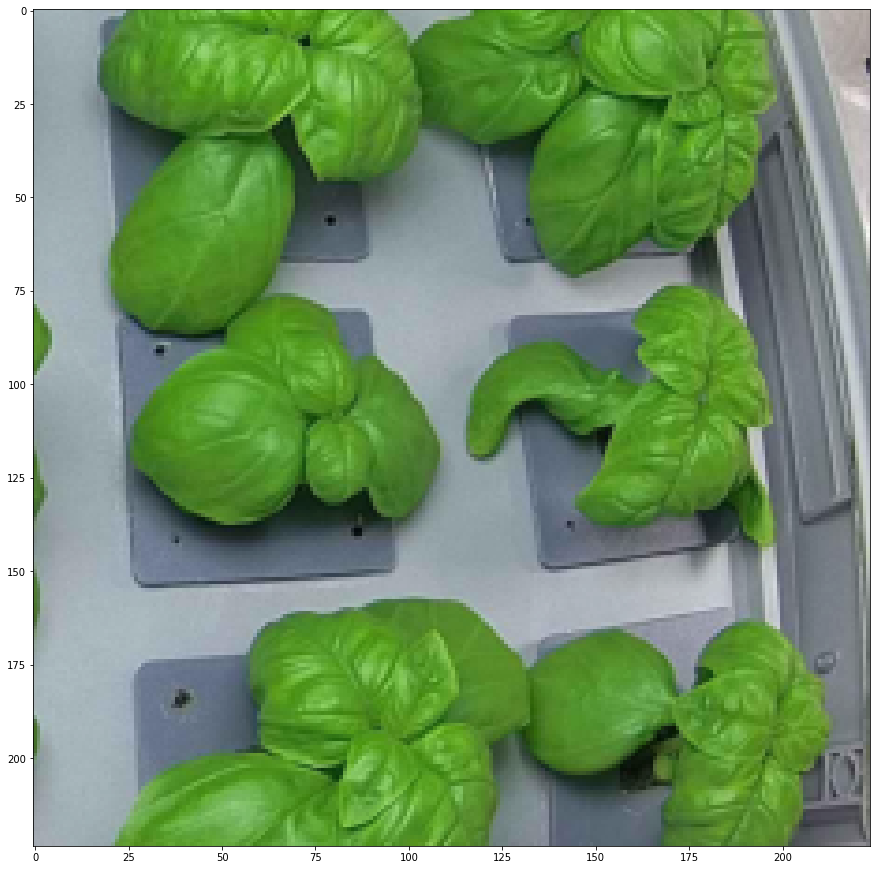

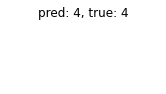

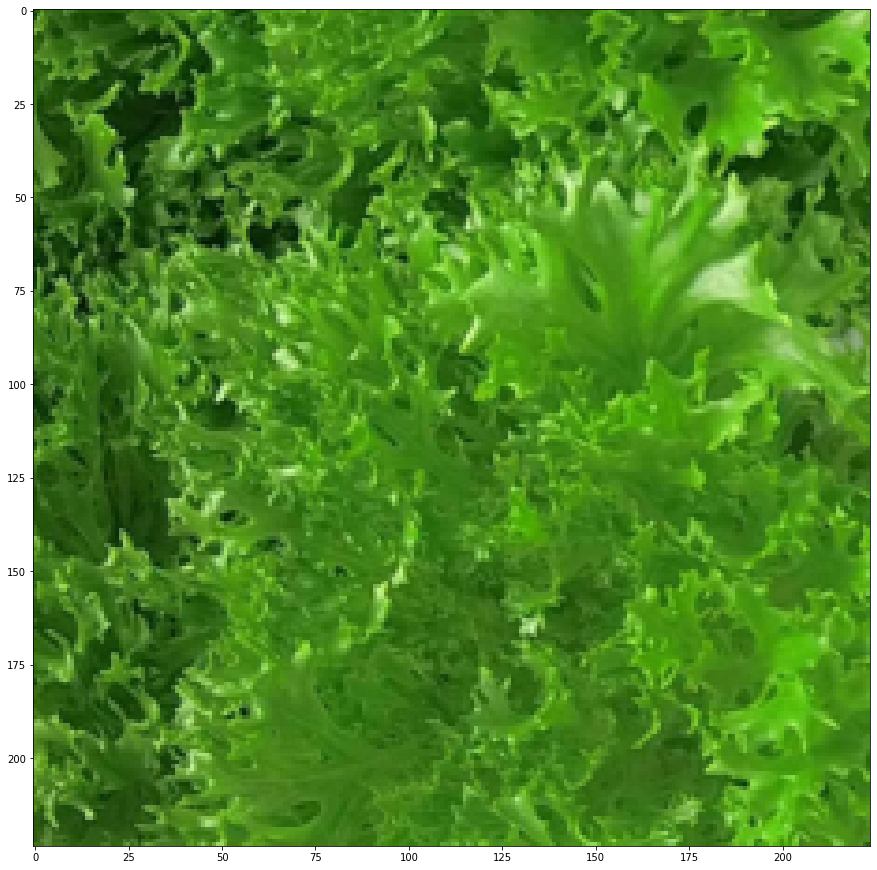

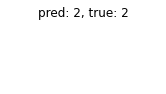

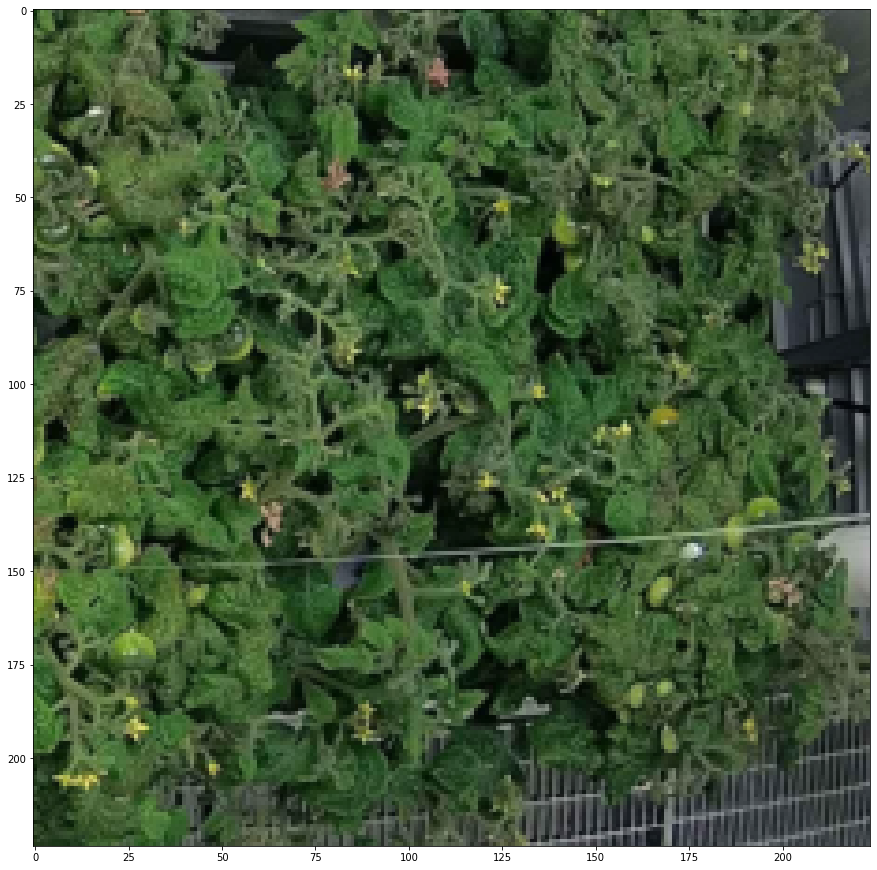

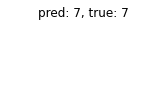

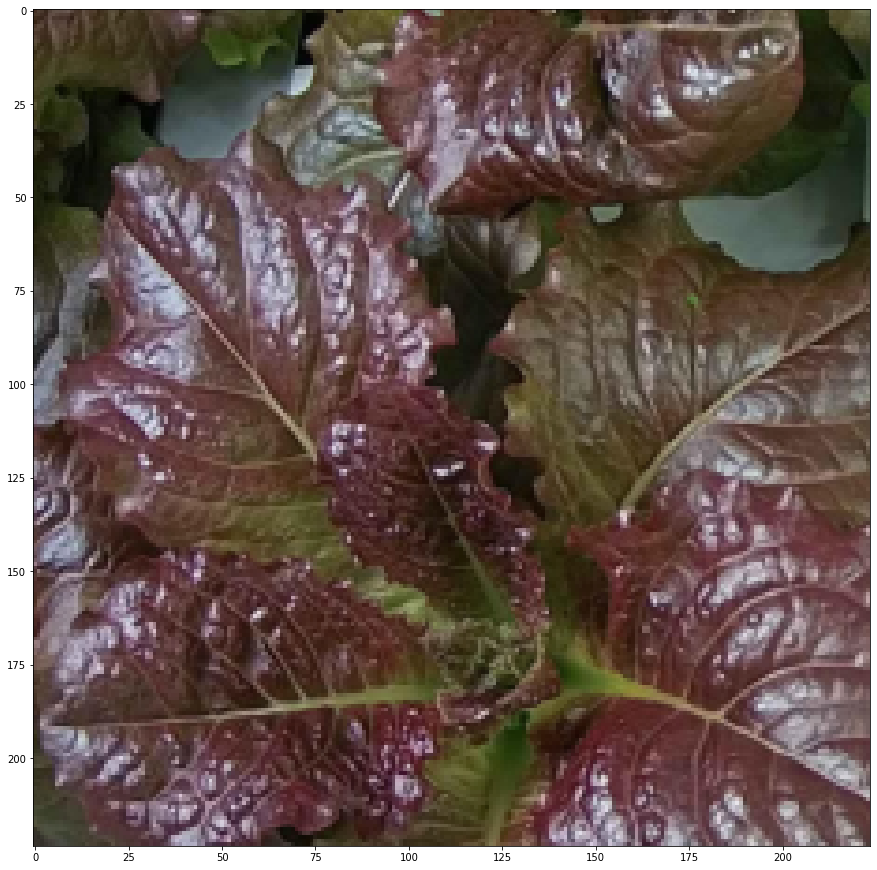

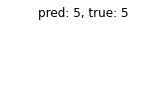

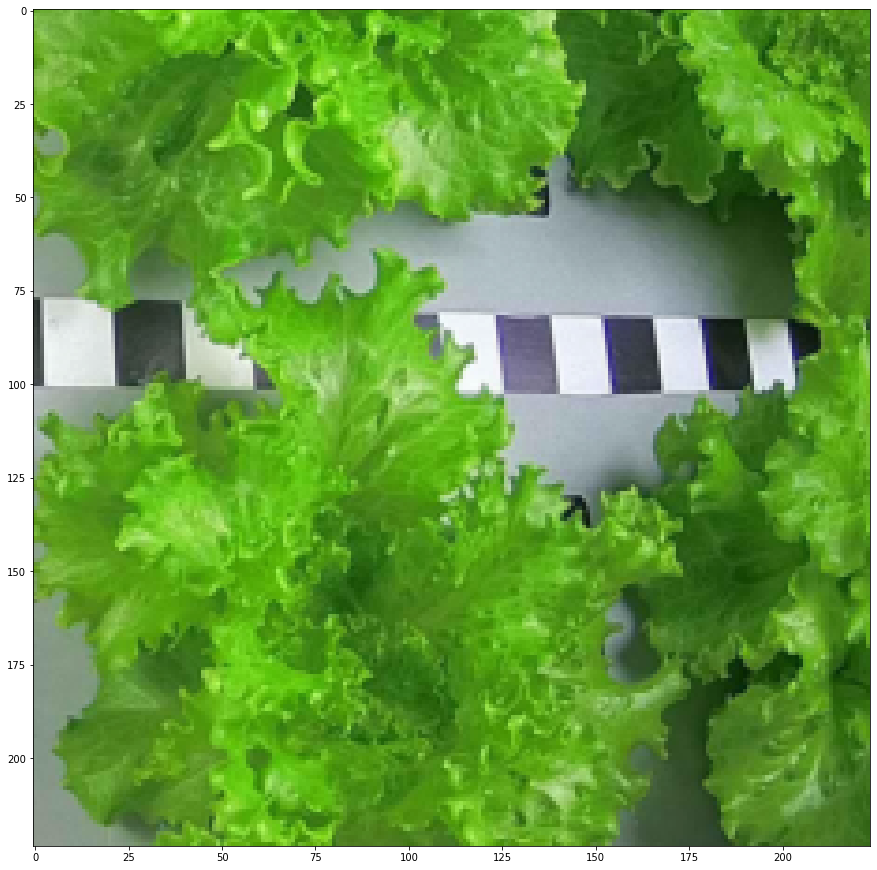

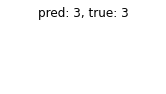

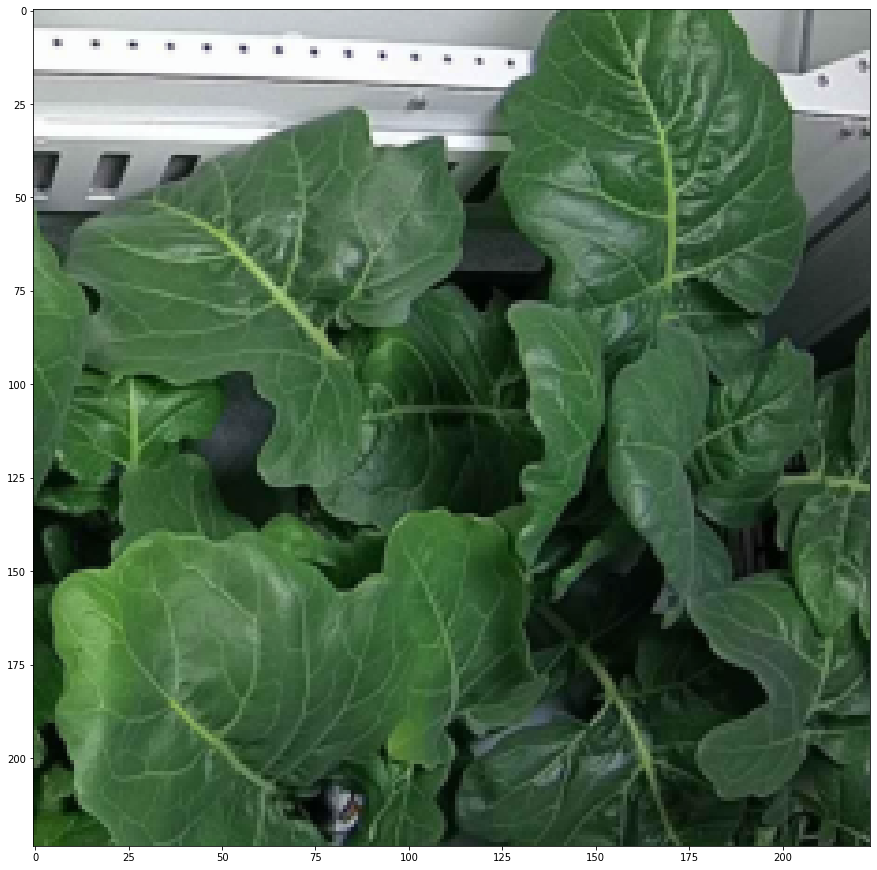

In [18]:
visualize_model(model_ft_loaded)